### LSTM-based Recurrent Neural Network (RNN) to predict SBIN (State Bank of India) stock price

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nifty50-stock-market-data/TCS.csv
/kaggle/input/nifty50-stock-market-data/MARUTI.csv
/kaggle/input/nifty50-stock-market-data/ONGC.csv
/kaggle/input/nifty50-stock-market-data/TITAN.csv
/kaggle/input/nifty50-stock-market-data/KOTAKBANK.csv
/kaggle/input/nifty50-stock-market-data/BAJFINANCE.csv
/kaggle/input/nifty50-stock-market-data/ASIANPAINT.csv
/kaggle/input/nifty50-stock-market-data/IOC.csv
/kaggle/input/nifty50-stock-market-data/INFRATEL.csv
/kaggle/input/nifty50-stock-market-data/TATASTEEL.csv
/kaggle/input/nifty50-stock-market-data/TATAMOTORS.csv
/kaggle/input/nifty50-stock-market-data/BHARTIARTL.csv
/kaggle/input/nifty50-stock-market-data/BPCL.csv
/kaggle/input/nifty50-stock-market-data/HDFCBANK.csv
/kaggle/input/nifty50-stock-market-data/BRITANNIA.csv
/kaggle/input/nifty50-stock-market-data/POWERGRID.csv
/kaggle/input/nifty50-stock-market-data/WIPRO.csv
/kaggle/input/nifty50-stock-market-data/DRREDDY.csv
/kaggle/input/nifty50-stock-market-data/ITC.csv
/kaggle/input

In [45]:
### Importing Required Libraries ###

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

**Reading SBIN data from NIFTY 50 dataset**

In [46]:
#read the file
df = pd.read_csv("../input/nifty50-stock-market-data/SBIN.csv")

#print the head
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,SBIN,EQ,225.60,236.00,243.65,234.25,243.65,243.65,240.83,2373228,5.715338e+13,NaN,NaN,NaN
1,2000-01-04,SBIN,EQ,243.65,243.65,262.00,238.85,258.00,259.10,251.46,4495741,1.130506e+14,NaN,NaN,NaN
2,2000-01-05,SBIN,EQ,259.10,249.00,264.70,245.00,249.05,248.45,252.35,3434058,8.666008e+13,NaN,NaN,NaN
3,2000-01-06,SBIN,EQ,248.45,252.00,268.00,252.00,260.50,261.00,262.18,6658801,1.745817e+14,NaN,NaN,NaN
4,2000-01-07,SBIN,EQ,261.00,261.50,279.90,255.00,279.00,273.30,269.02,7873985,2.118287e+14,NaN,NaN,NaN


Setting Date as Index. We will use **Close** Price for prediction

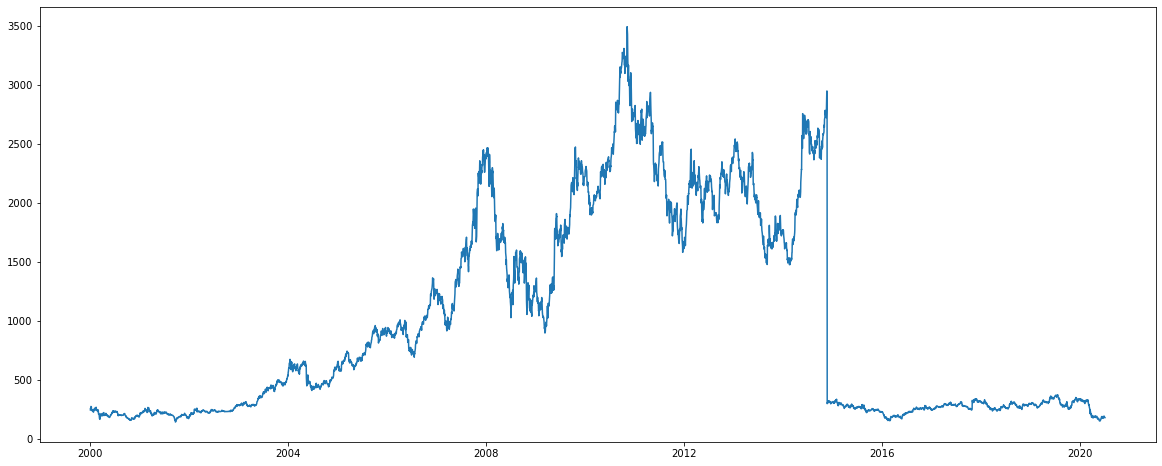

In [47]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(20,8))
plt.plot(df['Close'], label='Historical Close Price')

Selecting Close Price as feature and removing other columns from the data

In [48]:
features = ["Date", "Close"]
all_data = df[features]

In [49]:
#setting index
all_data.index = all_data.Date
all_data.drop('Date', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [50]:
all_data.head()

,Close
Date,
2000-01-03,243.65
2000-01-04,259.10
2000-01-05,248.45
2000-01-06,261.00
2000-01-07,273.30


In [51]:
all_data.shape

(5097, 1)

In [52]:
#creating training and validation sets
dataset = all_data.values

train = dataset[2000:4500,:]
valid = dataset[4500:,:]

### Feature Scaling

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

### Creating Sliding Window of 90 days

This data structure is needed to cover 90-days close price stamps, based on which RNN will predict the 91st day's close price. 

In [54]:
x_train, y_train = [], []
for i in range(90,len(train)):
    x_train.append(scaled_data[i-90:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#### Data Reshaping 

In [55]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Model Building

Initializing the LSTM model and 2nd, 3rd and 4th LSTM layer each with a Dropout Layer. The layers contain 50 neurons and with a Dropout rate of 20%, twenty percent of 50 neurons will be ignored randomly during each iteration

Finally, an output layer is added with 1 as an output dimension (as we are predicting the close price)

In [56]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(rate = 0.2))

model.add(Dense(1))

Compiling the model with **Stochastic Gradient Descent** algorithm 

Using Mean Squared Error as Loss Function

In [57]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [58]:
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
38/38 [==============================] - 10s 264ms/step - loss: 0.0091
Epoch 2/100
38/38 [==============================] - 9s 237ms/step - loss: 0.0018
Epoch 3/100
38/38 [==============================] - 9s 236ms/step - loss: 0.0016
Epoch 4/100
38/38 [==============================] - 9s 239ms/step - loss: 0.0014
Epoch 5/100
38/38 [==============================] - 10s 273ms/step - loss: 0.0014
Epoch 6/100
38/38 [==============================] - 11s 294ms/step - loss: 0.0015
Epoch 7/100
38/38 [==============================] - 10s 269ms/step - loss: 0.0013
Epoch 8/100
38/38 [==============================] - 9s 237ms/step - loss: 0.0011
Epoch 9/100
38/38 [==============================] - 9s 235ms/step - loss: 0.0013
Epoch 10/100
38/38 [==============================] - 9s 229ms/step - loss: 0.0012
Epoch 11/100
38/38 [==============================] - 9s 237ms/step - loss: 0.0012
Epoch 12/100
38/38 [==============================] - 9s 238ms/step - loss: 0.0012
Epoch 13/

38/38 [==============================] - 8s 218ms/step - loss: 4.5419e-04
Epoch 96/100
38/38 [==============================] - 8s 209ms/step - loss: 4.7613e-04
Epoch 97/100
38/38 [==============================] - 8s 212ms/step - loss: 5.6010e-04
Epoch 98/100
38/38 [==============================] - 8s 207ms/step - loss: 6.2334e-04
Epoch 99/100
38/38 [==============================] - 8s 211ms/step - loss: 4.7824e-04
Epoch 100/100
38/38 [==============================] - 8s 211ms/step - loss: 4.8803e-04


### Preparing the Test data for prediction

In [59]:
#predicting test data values, using past 90 from the train data
inputs = all_data[len(all_data) - len(valid)-90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [60]:
inputs.shape

(687, 1)

In [61]:
X_test = []
for i in range(90,inputs.shape[0]):
    X_test.append(inputs[i-90:i,0])
X_test = np.array(X_test)

In [62]:
X_test

array([[0.03883829, 0.03850978, 0.03773331, ..., 0.05011199, 0.04929073,
        0.05275496],
       [0.03850978, 0.03773331, 0.03840526, ..., 0.04929073, 0.05275496,
        0.05627893],
       [0.03773331, 0.03840526, 0.03794236, ..., 0.05275496, 0.05627893,
        0.05127669],
       ...,
       [0.05462147, 0.05338211, 0.05554726, ..., 0.0152307 , 0.01288637,
        0.01308048],
       [0.05338211, 0.05554726, 0.0531432 , ..., 0.01288637, 0.01308048,
        0.01288637],
       [0.05554726, 0.0531432 , 0.05159026, ..., 0.01308048, 0.01288637,
        0.01128864]])

In [63]:
X_test.shape

(597, 90)

In [68]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

In [73]:
preds

array([[343.45282],
       [347.71405],
       [351.2092 ],
       [352.6079 ],
       [352.40323],
       [351.46536],
       [349.69052],
       [346.56522],
       [342.8512 ],
       [338.8523 ],
       [335.30087],
       [333.6116 ],
       [333.23682],
       [332.5936 ],
       [329.95758],
       [326.08655],
       [321.5318 ],
       [316.8585 ],
       [312.9202 ],
       [310.54852],
       [309.60696],
       [309.91522],
       [310.7445 ],
       [310.80777],
       [309.97467],
       [308.09183],
       [305.83655],
       [303.13647],
       [299.33878],
       [296.0816 ],
       [293.84406],
       [292.51108],
       [292.01434],
       [292.32965],
       [292.7644 ],
       [292.8062 ],
       [291.9903 ],
       [290.69308],
       [289.29553],
       [287.43115],
       [284.6047 ],
       [282.52863],
       [282.6806 ],
       [284.2044 ],
       [285.5898 ],
       [286.67352],
       [287.1633 ],
       [288.3637 ],
       [290.4509 ],
       [292.9282 ],


### Calculating the RMSE to evaluate the model performance

In [75]:
rms=np.sqrt(np.mean(np.power((valid-preds),2)))

### Plotting the output

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'SBIN price prediction')

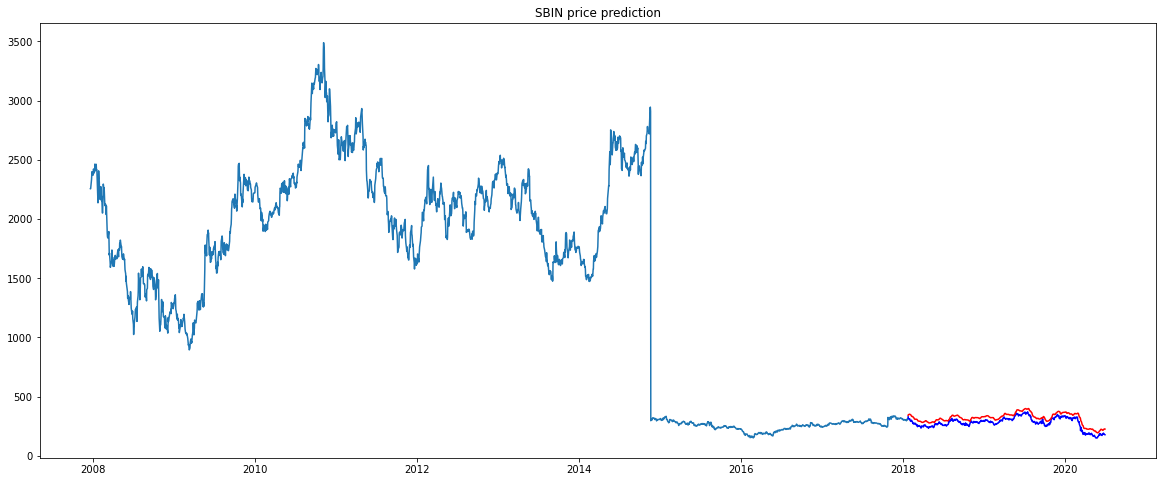

In [87]:
#for plotting
train = all_data[2000:4500]
valid = all_data[4500:]
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'blue', label = 'Real Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Price')
plt.title('SBIN price prediction')
plt.legend()
plt.show()